#### Training

This notebook contains code to train the model for crypt segmentation in colon images.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
#import libraries
import os
import warnings
from ast import literal_eval
import random
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch
import segmentation_models_pytorch as sm
import numpy as np
import pandas as pd
import skimage.io as io
from PIL import Image
import cv2
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import tifffile
from sklearn.model_selection import KFold
import glob
import torch_optimizer as t_optim
import utils
import cv2
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import OneCycleLR
import zarr


We convert the dataset to Zarr groups for fast retrieval - **just run one time i.e., first time** 
For future runs, run directly from the Dataset sub

In [3]:
train_images_path = "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/train/image/"
train_mask_path = "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/train/label/"
valid_images_path = "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/val/image/"
valid_mask_path =  "/N/scratch/joshisri/Roof_segmentation/Spring22/Roof_Segmentation/AIRS/trainval/val/label/"


In [14]:
data_train = []
for im in os.listdir(train_images_path):
    data_train.append([im,train_images_path+im,train_mask_path+im,0])
    if not os.path.isfile(train_images_path+im) and not os.path.isfile(train_mask_path+im):
        print(train_images_path+im)
        
        
data_valid= []
for im in os.listdir(valid_images_path):
    data_valid.append([im,valid_images_path+im,valid_mask_path+im,0])
    if not os.path.isfile(valid_images_path+im) and not os.path.isfile(valid_mask_path+im):
        print(valid_images_path+im)

            


In [20]:
pd.DataFrame(data_train,columns=["filename","image_path","mask_path","annot_counts"]).to_csv("train_data.csv",index=None)
pd.DataFrame(data_valid,columns=["filename","image_path","mask_path","annot_counts"]).to_csv("valid_data.csv",index=None)

In [21]:
train_images_zarr_savepath = "train_images_zarr"
train_masks_zarr_savepath = "train_masks_zarr"
val_images_zarr_savepath = "val_images_zarr"
val_masks_zarr_savepath = "val_masks_zarr"

In [22]:
train_img_group = zarr.group(train_images_zarr_savepath)
train_mask_group = zarr.group(train_masks_zarr_savepath)
val_img_grp =  zarr.group(val_images_zarr_savepath)
val_mask_grp =  zarr.group(val_masks_zarr_savepath)

Reading csvs 

In [44]:
train_csv = pd.read_csv("train_data.csv")
valid_csv = pd.read_csv("valid_data.csv")

In [45]:
mask_centroid_lists = []
for data in tqdm( train_csv.iterrows()):
    cent = []
    mask = tifffile.imread(data[1]['mask_path'])
    contours, hierarchies = cv2.findContours(np.uint8(mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # print(contour_random_selected)
    for c in contours:
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        cent.append([cx,cy])
    mask_centroid_lists.append(cent)
    

mask_centroids_val = []
for data in tqdm( valid_csv.iterrows()):
    cent = []
    mask = tifffile.imread(data[1]['mask_path'])
    contours, hierarchies = cv2.findContours(np.uint8(mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # print(contour_random_selected)
    for c in contours:
        M = cv2.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
        cent.append([cx,cy])
        
    mask_centroids_val.append(cent)

   
    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [46]:
train_csv['region_centroids'] = mask_centroid_lists
valid_csv['region_centroids'] = mask_centroids_val

train_csv.to_csv("train_data.csv",index=None)
valid_csv.to_csv("valid_data.csv",index=None)

In [26]:
for data in tqdm( train_csv.iterrows(),total=len(train_csv)):
    train_img_group[data[1]["filename"]] = tifffile.imread(data[1]['image_path'])
    train_mask_group[data[1]["filename"]] = tifffile.imread(data[1]['mask_path'])
    
    

  0%|          | 0/857 [00:00<?, ?it/s]

In [27]:
for data in tqdm( valid_csv.iterrows(),total=len(valid_csv)):
    val_img_grp[data[1]["filename"]] = tifffile.imread(data[1]['image_path'])
    val_mask_grp[data[1]["filename"]] = tifffile.imread(data[1]['mask_path'])
    
    

  0%|          | 0/94 [00:00<?, ?it/s]

### Dataset

In [4]:
        
class AIRS_dataset_dynamic(Dataset):
    def __init__(self,data_csv_path:str="train_data.csv",zarr_im_path="",zarr_mask_path="",indexes:list= None,transform:transforms = None, target_transform:transforms=None,preprocessing=None,patch_size=(512,512,3)):
        self.data = pd.read_csv(data_csv_path)
        self.indexed_data = self.data.iloc[indexes,:]
        self.transform = transform
        self.target_transform = target_transform
        self.preprocessing = preprocessing
        self.patch_size = patch_size
        self.image_zar = zarr.open_group(zarr_im_path)
        self.mask_zar = zarr.open_group(zarr_mask_path)
        
    def __getitem__(self,idx):
        # print("imname",self.indexed_data.iloc[idx,1])
        image = self.image_zar[self.indexed_data.iloc[idx,0]]#tifffile.imread(self.indexed_data.iloc[idx,0])
        mask =  self.mask_zar[self.indexed_data.iloc[idx,0]]#tifffile.imread(self.indexed_data.iloc[idx,2]).astype(np.uint8) * 255.
        cent_list = literal_eval(self.indexed_data.iloc[idx,-1])
        
        if len(cent_list)==0:
            cy,cx = random.randint(0,image.shape[1]),random.randint(0,image.shape[0])
        else:
            cy,cx = random.sample(cent_list,1)[0]
        cx = cx-self.patch_size[0]//2 if cx-self.patch_size[0]//2>0 else 0
        cy = cy-256 if cy-256>0 else 0
        
        cx = cx if cx+self.patch_size[0]<image.shape[0] else cx-self.patch_size[0]
        cy = cy if cy+self.patch_size[1]<image.shape[1] else cy-self.patch_size[1]
       
        patch =image.get_basic_selection((slice(cx,cx+self.patch_size[0]),slice(cy,cy+self.patch_size[1])))
        mask_patch =mask.get_basic_selection((slice(cx,cx+self.patch_size[0]),slice(cy,cy+self.patch_size[1])))*255.0
        if self.transform:
            augmentations = self.transform(image=patch,mask=mask_patch)
            patch,mask_patch = augmentations['image'],augmentations['mask']
        if self.preprocessing:
            preprocessed = self.preprocessing(image=patch,mask=mask_patch)
            patch,mask_patch = preprocessed['image'],preprocessed['mask']
        return patch.float(),(mask_patch[:,:]/255.0).type(torch.LongTensor)
    
    def __len__(self):
        return len(self.indexed_data)  
    
    
    
# class AIRS_dataset(Dataset):
#     def __init__(self,data_csv_path:str="train_data.csv",indexes:list= None,valid:bool=False,transform:transforms = None, target_transform:transforms=None,preprocessing=None):
#         self.data = pd.read_csv(data_csv_path)
#         self.indexed_data = self.data.iloc[indexes,:]
#         self.transform = transform
#         self.target_transform = target_transform
#         self.preprocessing = preprocessing
        
#     def __getitem__(self,idx):
        
#         image = tifffile.imread(self.indexed_data.iloc[idx,1])
#         mask = tifffile.imread(self.indexed_data.iloc[idx,2]).astype(float) * 255.
        
#         if self.transform:
#             augmentations = self.transform(image=image,mask=mask)
#             image,mask = augmentations['image'],augmentations['mask']
            
            
#         if self.preprocessing:
#             preprocessed = self.preprocessing(image=image,mask=mask)
#             image,mask = preprocessed['image'],preprocessed['mask']
#         # print(mask.shape)
#         return image.float(),(mask[:,:]/255.0).type(torch.LongTensor)
    
#     def __len__(self):
#         return len(self.indexed_data)  

### Config 

In [10]:
#Defining configurations
class Configuration:
    MODEL_SAVEPATH = "models/"
    ENCODER = "efficientnet-b2"
    PRETRAINED_WEIGHTS = "imagenet"
    BATCH_SIZE = 16
    INPUT_CHANNELS = 3
    INPUT_SHAPE = (512,512,3)
    ACTIVATION = None
    CLASSES = 2 
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    EPOCHS = 25
    LOSS_CROSSENTROPY = nn.CrossEntropyLoss() 
    LOSS_DICE = utils.DiceScore(loss=True)#utils.DiceLoss()
    DICE_COEF = utils.DiceScore(loss=False)#utils.DiceScore()
    WEIGHT_DECAY = 1e-4
    LEARNING_RATE = 1e-3
    PREPROCESS = sm.encoders.get_preprocessing_fn(ENCODER,PRETRAINED_WEIGHTS)
    ONECYCLELR = False
    MODEL_NAME = 0
    ARCHITECTURE = "UNET"
    MAX_LR_FOR_ONECYCLELR = 1e-3
       
cfg = Configuration()  

Testing dataset implementation

In [12]:
train_data_csv_path = "train_data.csv"
train_images_zarr_path = "train_images_zarr"
train_masks_zarr_path = "train_masks_zarr"
dataframe_im_ids = pd.read_csv(train_data_csv_path).index

In [13]:
train_dataset = AIRS_dataset_dynamic(train_data_csv_path,indexes=dataframe_im_ids,zarr_im_path=train_images_zarr_path,zarr_mask_path=train_masks_zarr_path,transform=utils.get_train_transforms(),preprocessing=utils.preprocessing_fucntion(cfg.PREPROCESS))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


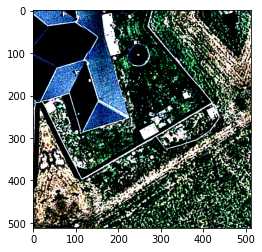

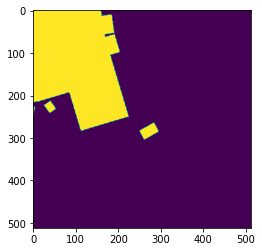

In [14]:
image,mask = train_dataset[0]
plt.imshow(image.numpy().transpose(1,2,0))
plt.show()
plt.imshow(mask)
plt.show()

Trainer class

In [15]:
class Trainer:
    def __init__(self,cfg:Configuration,train_data_loader:DataLoader,valid_data_loader:DataLoader)->None:
        self.cfg = cfg
        self.patience = 5
        self.model = sm.Unet(encoder_name=self.cfg.ENCODER, 
                     encoder_weights=self.cfg.PRETRAINED_WEIGHTS, 
                     in_channels=self.cfg.INPUT_CHANNELS, 
                     classes=self.cfg.CLASSES)
        self.loss_function = self.cfg.LOSS_CROSSENTROPY
        self.lr = self.cfg.LEARNING_RATE
        self.batch_size = self.cfg.BATCH_SIZE
        self.train_dataloader = train_data_loader
        self.valid_dataloader = valid_data_loader
        self.device = self.cfg.DEVICE
        self.epochs = self.cfg.EPOCHS
        self.lr = 1e-3
        self.track_best_valid = []
        self.val_for_early_stopping = 9999999
        if not os.path.isdir(self.cfg.MODEL_SAVEPATH):
            os.makedirs(self.cfg.MODEL_SAVEPATH)
        
        
            
            
        self.log = pd.DataFrame(columns=["model_name","train_loss","train_dice","valid_loss","valid_dice"])
        
        
        
        self.optimizer = t_optim.Ranger(self.model.parameters(),weight_decay=self.cfg.WEIGHT_DECAY)
        if self.cfg.ONECYCLELR:
            self.optimizer = OneCycleLR(self.optimizer, max_lr=self.cfg.MAX_LR_FOR_ONECYCLELR, steps_per_epoch=len(self.train_dataloader), epochs=self.EPOCHS)
        
   
    
    def calculate_metrics(self,data_loader:DataLoader):
        self.model.eval()
        total_loss = 0
        total_dice = 0 #batch wise dice loss
        with torch.no_grad():
            for data in tqdm(data_loader,total=len(data_loader)):
                im = data[0].to(self.device)
                mask = data[1].to(self.device)
                out = self.model(im)
                loss = self.loss_function(out.data,mask) #+ cfg.LOSS_DICE(out,mask)
                total_loss+=loss.item()
                total_dice+= self.cfg.DICE_COEF(out.data.to("cpu"),mask.cpu())
        return total_dice/len(data_loader),total_loss/len(data_loader)

    
    def earlystopping(self,val_loss):
        
        if val_loss < self.val_for_early_stopping:
            self.val_for_early_stopping = val_loss
            return True
        else:
            self.patience-=1
            return False
 
    def fit(self)->None:
        print("started fitting the model")
        best_loss = 9999999
        
        for epoch in range(self.epochs):
            self.model.train()
            self.model.to(self.device)
            
            dice_score_ = 0
            loss_ = 0
            
            for j,data in enumerate(tqdm(self.train_dataloader,total = len(self.train_dataloader))):
                input_image_batch = data[0].to(self.device)
                mask_batch = data[1].to(self.device)
                self.optimizer.zero_grad()
                output = self.model(input_image_batch)
                loss = self.loss_function(output,mask_batch)#+cfg.LOSS_DICE(output,mask_batch.unsqueeze(1))
                loss.backward()
                self.optimizer.step()
                loss_+=loss.item()
            
                dice_score_+= self.cfg.DICE_COEF(output.data.to("cpu"),mask_batch.to("cpu"))

            
            dice_score_valid,loss_valid, = self.calculate_metrics(self.valid_dataloader)
            train_dice = dice_score_/len(self.train_dataloader)
            train_loss = loss_/len(self.train_dataloader)
            print(f"train dice score : {train_dice}, train loss {train_loss}")
            print(f"valid dice score : {dice_score_valid}, valid loss {loss_valid}")
            
            self.log.loc[epoch,:] = [f"fold_{self.cfg.ENCODER}_{self.cfg.ENCODER}.pth",f"{train_loss}",f"{train_dice}",f"{loss_valid}",f"{dice_score_valid}"]
            self.log.to_csv(self.cfg.MODEL_SAVEPATH+f"/fold_{self.cfg.MODEL_NAME}__{self.cfg.ENCODER}_{self.cfg.BATCH_SIZE}_CE_Valid_slicing_all.csv",index=False)
            
            if self.patience >= 0 and self.earlystopping(loss_valid):
                print("saving model")
                
                torch.save(self.model.state_dict(),self.cfg.MODEL_SAVEPATH+f"/fold_{self.cfg.MODEL_NAME}_{self.cfg.ENCODER}_{self.cfg.BATCH_SIZE}_CE_Valid_slicing_all.pth")
                self.patience= 5
                
            
            if self.patience <= 0:
                print("Training terminated, no improvement in valid loss")
                break
                
        
        
        

        

#### Model Training

In [16]:
train_data_csv_path = "train_data.csv"
valid_data_csv_path = "valid_data.csv"

train_images_zarr_path = "train_images_zarr"
train_masks_zarr_path = "train_masks_zarr"
val_images_zarr_path = "val_images_zarr"
val_masks_zarr_path = "val_masks_zarr"

def training(train_data_csv_path:str,valid_data_csv_path:str)->pd.DataFrame:
    #get all the training data unique image ids
    train_ids = pd.read_csv(train_data_csv_path).index
    valid_ids = pd.read_csv(valid_data_csv_path).index
    
    train_dataset = AIRS_dataset_dynamic(train_data_csv_path,indexes=train_ids,zarr_im_path=train_images_zarr_path,zarr_mask_path=train_masks_zarr_path,transform=utils.get_train_transforms(),preprocessing=utils.preprocessing_fucntion(cfg.PREPROCESS))
    valid_dataset = AIRS_dataset_dynamic(valid_data_csv_path,indexes=valid_ids,zarr_im_path=val_images_zarr_path,zarr_mask_path=val_masks_zarr_path,preprocessing=utils.preprocessing_fucntion(cfg.PREPROCESS))

    train_dataloader = DataLoader(train_dataset,batch_size=cfg.BATCH_SIZE,shuffle=True)
    valid_dataloader = DataLoader(valid_dataset,batch_size=cfg.BATCH_SIZE,shuffle=False)
    cfg.MODEL_NAME =   "_"+cfg.ARCHITECTURE
    trainer =Trainer(cfg,train_dataloader,valid_dataloader)
    trainer.fit()        



    


In [ ]:
training(train_data_csv_path,valid_data_csv_path)

started fitting the model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.6975229978561401, train loss 0.5303895031964337
valid dice score : 0.7134526371955872, valid loss 0.41591477394104004
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.7673292756080627, train loss 0.3420560252335336
valid dice score : 0.8060415387153625, valid loss 0.2718699872493744
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.8446205258369446, train loss 0.22952296695223562
valid dice score : 0.8999901413917542, valid loss 0.14819522326191267
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.8948512077331543, train loss 0.1660132634418982
valid dice score : 0.9251563549041748, valid loss 0.11310757199923198
saving model


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

train dice score : 0.9120025634765625, train loss 0.1436677889691459
valid dice score : 0.9337067008018494, valid loss 0.11067037160197894
saving model


  0%|          | 0/54 [00:00<?, ?it/s]